# Loop Invariants
(not ready)

## Longest Palindromic Substring (LPS)

The LPS problem consists of finding the longest substring of a given string that is a [palindrome](https://en.wikipedia.org/wiki/Palindrome), i.e., a string that reads the same backwards as forwards.

Odd length palindromes are symmetric around a central character and the problem of finding the longest odd length palindromic substring is slightly easier than the general LPS problem.

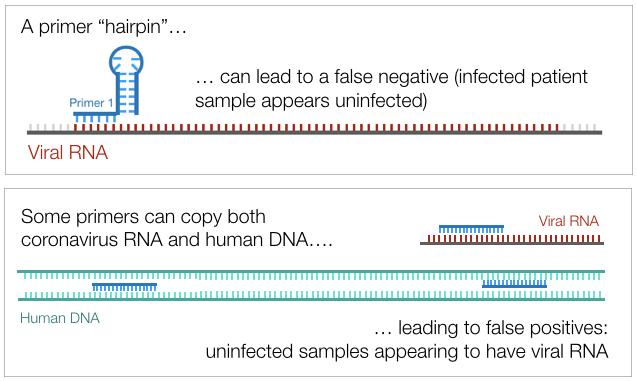

### A naive approach

For every character in the given string, find the longest odd-length palindromic substring (LOPS) centered at that character while keeping track of the LOPS found so far:

In [ ]:
def lops_naive(s):
    n = len(s)
    max_ctr, max_radius = 0, 0
    for ctr in range(len(s)):
        start = end = ctr
        while 0 < start and end < n - 1 and s[start - 1] == s[end + 1]:
            # start and end are symmetric wrt to ctr
            # s[start:end + 1] is palindromic
            start, end = start - 1, end + 1
        # s[start:end + 1] is the longest palindormic substring centered at ctr
        if end - ctr > max_radius:
            max_ctr, max_radius = ctr, end - ctr
        # max_ctr is the center of the longest odd length palindrome in s[:ctr + 1]
        # max_radius is the radius of the longest odd length palindrome in s[:ctr + 1]
    return s[max_ctr - max_radius:max_ctr + max_radius + 1]

lops_naive('aracecar')

In [ ]:
lops_naive('ANABBAB')

In [ ]:
lops_naive('|A|N|A|B|B|A|')

The time complexity of `lops_naive` is O(n^2), which is noticeable when applying it to, e.g., `'a' * 10000`

In [ ]:
%timeit -n1 -r1 len(lops_naive('a' * 10000))

### A linear approach; [Manacher's algorithm](https://en.wikipedia.org/wiki/Longest_palindromic_substring#Manacher's_algorithm)

In this approach, we keep track of the lengths of the palindromic substrings in an array `r`. 

At some point during the execution of the algorithm, we'll have the following situation:

**Situation I:** *The variable `ctr` points to some character of the input string, `start` and `end` point to the first and last characters of the longest palindromic substring centered at `ctr`, and `r[k]` has been computed for all `k` where `0 <= k <= ctr`.*

This situation can be illustrated by:

<img src="assets/longest_palindrome.svg"/>

The next step of the algorithm is to try and populate `r[j]` for `ctr < j <= end` based on `r[i]`, where `i` is symmetric to `j` with respect to `ctr`, i.e., `i = ctr - (j - ctr)`. 

<img src="assets/longest_palindrome_3.svg"/>

There are three cases to consider depending on whether the longest palindromic substring centered at `i` starts before, at, or after `start`.

1. `start <  i - r[i]` => `r[j]  = r[i]`
2. `start >  i - r[i]` => `r[j]  = i - start`  
3. `start == i - r[i]` => `r[j] >= i - start`  

Note that cases 1 and 2 can be combined into one case `start != i - r[i]` => `r[j] = min(r[i], i - start)`.
In case 3, we don't know the radius to assign to `r[j]`, so we'll make `j` the _new_ `ctr`. 

What we have described so far can be translated into code as follows:

```Python
    ...
    # We have Situation I
    i, j = ctr - 1, ctr + 1
    while j <= end and start != i - r[i]:
        # Loop invariant: 
        # r[k] has been computed for 0 <= k < j
        # i is symmetric to j wrt ctr
        r[j] = min(r[i], i - start)
        i, j = i - 1, j + 1
    if j > end: 
        end = j
    ctr = j
```

Side note on while-loops with else clause:
The above loop could have been written:

```Python
    while j <= end:
        # Loop invariant: 
        # r[k] has been computed for 0 <= k < j
        # i is symmetric to j wrt ctr
        if start == i - r[i]:
            break
        r[j] = min(r[i], i - start)       
        i, j = i - 1, j + 1
    else: 
        end = j
    ctr = j
```

Which is best? You be the judge.

The situation right after is illustrated by:

<img src="assets/longest_palindrome_4.svg"/>

After making `j` the new `ctr`, we try and restore *Situation I*. In order to do that, we must update `start` and `end` and assign the correct value to `r[ctr]`.

```Python
    start = ctr - (end - ctr) # start is symmetric to end wrt ctr
    while 0 < start and end < n - 1 and s[start - 1] == s[end + 1]:
        # Loop invariant: 
        # s[start:end + 1] is palindromic
        # start is symmetric to end wrt ctr
        start, end = start - 1, end + 1
    r[ctr] = end - ctr
 ```

At this point we have *Situation I* again and we can loop back and repeat till we are done. In fact, *Situation I* is our loop invariant. We are done when `end == n - 1`, where `n` is the length of the input string. 

To establish *Situation I* the first time we reach the loop, we can assign `start = ctr = end = 0`. Putting all this together, we get:

In [ ]:
def lops(s):
    n = len(s)
    r = [0] * n
    start = ctr = end = 0
    while end < n - 1:
        # Loop invariant:
        # ctr is the index some character in s
        # start is the index of first character of the longest palindromic 
        # substring of s centered at ctr
        # end is the index of last character of the longest palindromic 
        # substring of s centered at ctr
        # r[k] == radius of the longest palindromic substring of s 
        # centered at k, for 0 <= k <= ctr
        i, j = ctr - 1, ctr + 1
        while j <= end and r[i] != i - start:
            r[j] = min(r[i], i - start)
            i, j = i - 1, j + 1
        if j > end: 
            end = j
        ctr = j
        start = ctr - (end - ctr)
        while 0 < start and end < n - 1 and s[start - 1] == s[end + 1]:
            start, end = start - 1, end + 1
        r[j] = end - ctr
    max_j = max(range(n), key=lambda k: r[k])
    return s[max_j - r[max_j]: max_j + r[max_j] + 1]

In [ ]:
lops('|A|N|A|B|B|A|B|')

In [ ]:
len(lops('a' * 1000000))

In [ ]:
%timeit len(lops('a' * 1000000))

#### Time complexity of Manecher's algorithm

Notice that the variables `j` and `end` are never reset or decremented and that they never surpass `n`. The variable `j` is incremented for each iteration of the first inner loop, which bounds the number of iterations of that loop summed over all iterations of the outer loop to `n`. Similarly, the variable `end` is incremented for each iteration of the second inner loop, which bounds the number of iterations of that loop summed over all iterations of the outer loop to `n`. Also, progress is made in each iteration of the outer loop, since both `j` and `end` are incremented in the outer loop. Since each iteration of the two inner loops takes constant time, the time complexity of the whole algorithm is O(n).

### LPS revisited

We can now provide the definition of LPS based on LOPS.

In [ ]:
def lps(s):
    s_sep = f'{"|"}{"|".join(s)}{"|"}'
    return ''.join(c for i, c in enumerate(lops(s_sep)) if i & 1)

In [ ]:
lps('ANABBA')

In [ ]:
len(lps('a'*1_000_000))

However, we don't need to allocate the memory for `s_sep` as shown above, since we know that 

```Python
s_sep[k] = '|' if k % 2 == 0 else s[k >> 1]
``` 
We can implement `lps` by modifying `lops`.

In [ ]:
def longest_palindrome(s):
    """
    Find the longest palindromic substring in s. If there are multiple such substrings,
    the first occurrence is returned.
    """
    # s_sep = '|' + '|'.join(s) + '|'
    n = 2 * len(s) + 1
    r = [0] * n
    start = max_j = ctr = end = 0
    while end < n - 1:
        # Loop invariant:
        # ctr is the index some character in s_sep
        # start is the index of first character of the longest palindromic 
        # substring of s_sep centered at ctr
        # end is the index of last character of the longest palindromic 
        # substring of s_sep centered at ctr
        # r[k] == radius of the longest palindromic substring of s_sep 
        # centered at k, for 0 <= k <= ctr
        # Note: start and end are even
        i, j = ctr - 1, ctr + 1
        while j <= end and r[i] != end - j:
            r[j] = min(r[i], i - start)
            i, j = i - 1, j + 1
        ctr = j
        if j > end: end = j + 1
        start = ctr - (end - ctr)
        while 0 < start and end < n - 1 and s[(start >> 1) - 1] == s[end >> 1]:
            start, end = start - 2, end + 2
        r[ctr] = end - ctr
        if r[ctr] > r[max_j]: max_j = ctr
    return s[max_j - r[max_j] >> 1: max_j + r[max_j] >> 1]

In [ ]:
longest_palindrome('ANABBA')

In [ ]:
longest_palindrome('BANANAS IN PAJAMAS')

In [ ]:
len(longest_palindrome('a' * 1000000))

In [ ]:
%timeit len(longest_palindrome('a' * 1000000))

In [ ]:
longest_palindrome('')

In [ ]:
def longest_palindrome_everted(s):
    """
    Find the longest palindromic substring in s. If there are multiple such substrings,
    the first occurrence is returned.
    """
    # s_sep = '|' + '|'.join(s) + '|'
    n = 2 * len(s) + 1
    r = [0] * n
    start = ctr = max_j = end = 0
    for j in range(1, n):
        if j <= end and r[i] != end - j:
            r[j] = min(r[i], end - j)
            i = i - 1
        else:
            ctr, end = j, max(end, j)
            start = ctr - (end - ctr)
            while start & 1 or 0 < start and end < n - 1 and s[(start >> 1) - 1] == s[end >> 1]:
                start, end = start - 1, end + 1
            r[ctr] = end - ctr
            i = ctr - 1
            if r[ctr] > r[max_j]: max_j = ctr
    return s[max_j - r[max_j] >> 1:max_j + r[max_j] >> 1]

In [ ]:
def longest_palindrome_everted(s):
    n = 2 * len(s) + 1
    r = [0] * n
    start = ctr = max_j = 0
    for end in range(n):
        while start & 1 == 0 and ctr <= end and (start == 0 or end == n - 1 or s[(start >> 1) - 1] != s[end >> 1]):
            r[ctr] = end - ctr
            if r[ctr] > r[max_j]: max_j = ctr
            i, j = ctr - 1, ctr + 1
            while j <= end and r[i] != end - j:
                r[j] = min(r[i], end - j)
                i, j = i - 1, j + 1
            ctr = j
            start = ctr - (end - ctr)
        start -= 1
    return s[max_j - r[max_j] >> 1:max_j + r[max_j] >> 1]

In [ ]:
longest_palindrome_everted('BANANAS IN PAJAMAS')

In [ ]:
# len(longest_palindrome('a' * 1_000_000))
def random_palindromes(chars, repetitions, size):
    d = defaultdict(int)
    for _ in range(repetitions):
        s = ''.join(choice(chars) for _ in range(size))
        p = longest_palindrome(s)
        d[len(p)] += 1
    return sorted(d.items())

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.axes as subfig
import numpy as np

from collections import defaultdict
from random import choice

In [ ]:
# res = random_palindromes('ucga', 1000, 1000000)
res = [(18, 8), (19, 125), (20, 164), (21, 336), (22, 111), (23, 156), (24, 39), (25, 33), (26, 8), (27, 12), (28, 6), (29, 2)]
x, y = (np.array(a) for a in zip(*res))
plt.bar(x, y)

In [ ]:
res

In [ ]:
res2 = [(18, 9),
 (19, 127),
 (20, 179),
 (21, 304),
 (22, 105),
 (23, 135),
 (24, 50),
 (25, 61),
 (26, 10),
 (27, 11),
 (28, 6),
 (29, 1),
 (30, 2)]

In [ ]:
sum(y[0:12:2])

In [ ]:
sum(y[1:12:2])

### Quicksort, 3-way partition

In [ ]:
from random import randrange, shuffle

def quick_sort(v, start, end):
    if end - start < 2: return
    pivot = v[randrange(start, end)]
    low, high = partition(v, pivot, start, end)
    quick_sort(v, start, low)
    quick_sort(v, high, end)
    

In [ ]:
def partition(v, pivot, start, end):
    """
    Reorders the elements of v so that:
        - all elements in v[:low] are less than p,
        - all elements in v[low:high] are equal to p,
        - all elements in v[high:] are greater than p.
    """
    low, mid, high = start, start, end
    for _ in range(high - mid):
        a = v[mid]
        if a < pivot:
            v[mid], v[low] = v[low], a
            low += 1
            mid += 1
        elif a == pivot:
            mid += 1
        else:
            high -= 1
            v[mid], v[high] = v[high], v[mid]
        #  - v[start:low] < pivot
        #  - v[low:mid] = pivot
        #  - v[mid:high] are unknown
        #  - v[high:end] > pivot
        #
        #     -----------------------------------------------
        # v: |    < p   |   = p    |  unknown    |   > p     |
        #     -----------------------------------------------
        #     ^          ^          ^             ^           ^
        #    start      low        mid           high         end


    return low, high

In [ ]:
def verify_quick_sort():
    a = [randrange(1000) for _ in range(1000000)]
    quick_sort(a, 0, len(a))
    return a == sorted(a)
    
verify_quick_sort()

In [ ]:
def test_quick_sort():
    a = [randrange(100) for _ in range(100000)]
    quick_sort(a, 0, len(a))

%timeit test_quick_sort()

In [ ]:
def test_tim_sort():
    a = [randrange(100) for _ in range(100000)]
    a.sort()

%timeit test_tim_sort()